In [1]:
from multiprocessing import Pool
import matplotlib.pyplot as plt
import pickle
from astropy.coordinates import SkyCoord, match_coordinates_3d, match_coordinates_sky
import sys
import emcee
import numpy as np
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from astropy.table import Table, QTable, hstack, vstack
from astropy import units as u
import corner, time
from astropy.coordinates import SkyCoord, match_coordinates_3d
cosmo_astropy = FlatLambdaCDM(H0=71.0, Om0=0.265, Ob0 = 0.0448)
import iminuit
from iminuit import Minuit
cosmo_astropy.critical_density(0.4).to(u.Msun / u.Mpc**3).value
sys.path.append('/pbs/throng/lsst/users/cpayerne/CLMassDC2/modules/')
#import CL_WL_miscentering as mis
import analysis_Mass_Richness_relation as analysis
import CL_WL_two_halo_term as twoh
import CL_WL_mass_conversion as utils
import CL_DATAOPS_match_catalogs as match
import CL_Mass_richness_relation as mr
import CL_Likelihood_for_Mass_richness_relation as likelihood_mr


import clmm
import clmm.dataops
from clmm.dataops import compute_tangential_and_cross_components, make_radial_profile, make_bins
from clmm.galaxycluster import GalaxyCluster
import clmm.utils as u
import astropy.units as un
from clmm import Cosmology
from clmm.support import mock_data as mock
import pyccl as ccl

def save_pickle(dat, filename, **kwargs):
    file = open(filename,'wb')
    pickle.dump(dat, file)
    file.close()

In [2]:
cosmo = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
cosmo_astropy = FlatLambdaCDM(H0=71.0, Om0=0.265, Ob0 = 0.0448)
cosmo_clmm = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
cosmo_ccl  = ccl.Cosmology(Omega_c=0.265-0.0448, Omega_b=0.0448, h=0.71, A_s=2.1e-9, n_s=0.96, Neff=0, Omega_g=0)

#data
data = np.load('/pbs/throng/lsst/users/cpayerne/CLMassDC2/notebooks/data_for_notebooks/stacked_esd_profiles_redmapper_true.pkl', allow_pickle=True)
profiles = data['stacked profile']
covariances = data['stacked covariance']
print(len(profiles))

#modeling of the mass-richness relation
MR_modeling = mr.WL_Mass_Richness()
MR_modeling.set_pivot_values(analysis.z0, analysis.richness0)

#modeling of the unitary excess surface density profile
def esd_modeling(R, log10m, c, z, cosmo, halo_profile = 'nfw'):
    return clmm.compute_excess_surface_density(R, 10**log10m, c, z, cosmo, delta_mdef=200,
                                       halo_profile_model=halo_profile, massdef='critical')

def esd_modeling_2h_nobias(R, z):
    moo = clmm.Modeling(massdef='critical', delta_mdef=200, halo_profile_model='nfw')
    moo.set_cosmo(cosmo)
    return moo.eval_excess_surface_density_2h(R, z, halobias=1)
deff = ccl.halos.massdef.MassDef(200, 'critical', c_m_relation=None)
concDiemer15 = ccl.halos.concentration.ConcentrationDiemer15(mdef=deff)

28


In [3]:
index = 1
richness = profiles['obs_individual'][index]
z = profiles['z_individual'][index]

In [4]:
m = 10**np.linspace(14, 15, len(z))

In [18]:
thetaMC = [14.14, -.1, .7]
thetaMC_sigma = [.0, 0, 0]
Model = mr.WL_Mass_Richness()
Model.set_pivot_values( analysis.z0, analysis.richness0)
mu_m = Model.lnM(richness, z, thetaMC)
sigma_m = Model.sigma_lnM(richness, z, thetaMC_sigma)
lnm = mu_m + np.random.randn(len(m))*sigma_m
m = np.exp(lnm)

(array([ 7., 11.,  8.,  7., 10.,  8.,  5., 10.,  5.,  2.]),
 array([14.21031975, 14.23129095, 14.25226214, 14.27323334, 14.29420454,
        14.31517573, 14.33614693, 14.35711813, 14.37808932, 14.39906052,
        14.42003171]),
 <BarContainer object of 10 artists>)

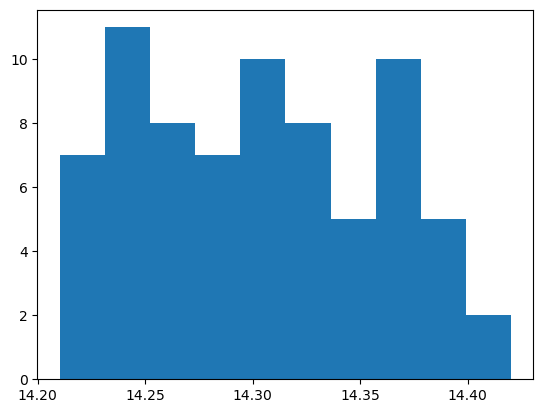

In [19]:
plt.hist(np.log10(m))

In [22]:
profiles

z_mean,obs_mean,obs_rms,radius,gt,gx,gt_individual,radius_individual,n_stack,cluster_id,z_individual,obs_individual,z_bin,obs_bin,W_l_true,richness,redshift,weight_per_cluster_true_5,weight_per_cluster_true_10,weight_per_cluster_bpz_5,weight_per_cluster_bpz_10,weight_per_cluster_flex_5,weight_per_cluster_flex_10
float32,float32,float64,float64[15],float64[15],float64[15],object,object,int64,object,object,object,float64[2],int64[2],object,object,object,object,object,object,object,object,object
0.25773725,26.190575,0.3811093770960364,0.5571484216137635 .. 9.12433179483314,62800794499069.52 .. 1894034260045.7598,-5234111075964.484 .. 93844399414.93367,DSt_true \n-----------------------------------------\n-1494634565705.1714 .. 316666442096.76654\n 16801777403648.424 .. 1222138397751.0078\n 60697976383996.93 .. 1986023925891.5115\n 122886045660205.2 .. -3259573796944.755\n 17143377596651.588 .. 8324305153197.107\n 40111126772429.26 .. 1244944682859.1897\n 89248877250566.64 .. -865663074532.1215\n 82946096370681.62 .. 3089012630584.2124\n 145814995709741.47 .. -7842705700609.579\n 12360325159172.629 .. 2156719642526.9463\n ...\n58710378605508.336 .. -1393347866395.4749\n 134833217727354.75 .. 2865898259866.6704\n 5257543790820.365 .. 8005925603728.707\n 50806103260342.26 .. 11578789553183.879\n 110439615517924.77 .. 2963118020386.018\n12781345096271.242 .. -10432290493110.207\n 52132041774146.8 .. -6010073348805.327\n 88022489603997.94 .. 1898376649600.5554\n 24154614369697.027 .. 3444242569618.3105\n 85164760198756.56 .. -438839411344.2328\n 92247143268251.94 .. -1799222655383.522\nLength = 140 rows,radius_true \n---------------------------------------\n0.5626195077823404 .. 9.127140612414093\n0.5584539578898104 .. 9.112816924454004\n 0.5556731735045112 .. 9.12397566831889\n0.5547550957530637 .. 9.121976830505151\n0.5574086679500796 .. 9.132301794980043\n0.5558950648584049 .. 9.122886539997602\n0.5592901582506177 .. 9.122235925935225\n0.5519740576032548 .. 9.121695695365007\n0.5556459831942344 .. 9.123600691769362\n0.5535891777856775 .. 9.087157800798003\n ...\n0.5569616347126289 .. 9.128589825473309\n 0.5486289505338977 .. 9.13051203116735\n0.5582376444654374 .. 9.127409156481406\n0.5568572613694891 .. 9.130440380932688\n 0.5557192830504635 .. 9.12824234290818\n 0.5573519750830618 .. 9.12622530046001\n0.5572740465083249 .. 9.125115107407037\n0.5560206315915808 .. 9.135518500074237\n0.5541472283698125 .. 9.128644180309562\n 0.5521560390998781 .. 9.12318103944399\n0.5570171437053134 .. 9.126346062076415\nLength = 140 rows,140,cluster_id\n----------\n 5827\n 5363\n 2780\n 3217\n 2408\n 5907\n 5020\n 1509\n 2928\n 1878\n ...\n 2010\n 3332\n 1545\n 3058\n 3871\n 3510\n 4700\n 2710\n 4971\n 2448\n 3245\nLength = 140 rows,redshift \n----------\n0.23056273\n0.28571928\n 0.2656841\n0.23977734\n0.23846887\n 0.2783501\n 0.2959632\n0.21490279\n0.23774967\n0.28370178\n ...\n0.20745204\n0.29559094\n0.23514748\n0.26828986\n0.26466498\n0.28070146\n 0.2672287\n0.22942036\n0.26627398\n 0.2649448\n0.25567377\nLength = 140 rows,richness\n---------\n 22.96295\n20.796743\n24.854567\n23.496874\n29.537844\n21.620512\n20.659449\n 31.76507\n28.073366\n34.694023\n ...\n21.574747\n26.395319\n34.907593\n25.037626\n 22.41377\n24.763037\n22.306986\n 28.27168\n 25.78512\n31.383696\n 28.36321\nLength = 140 rows,0.2 .. 0.3,20 .. 35,W_l_true \n------------------------------------------------\n1.3860832747420388e-29 .. 4.8702205864782505e-27\n1.6894886292148968e-29 .. 3.7197409709271515e-27\n 1.813100948349325e-29 .. 4.474630007729525e-27\n 1.6804729212939865e-29 .. 4.321428968081082e-27\n2.7068967990378446e-29 .. 4.7073945089219455e-27\n 1.9163190476405224e-29 .. 4.210343647476264e-27\n 1.5610612138799968e-29 .. 3.777108112819689e-27\n 1.6802055894123587e-29 .. 4.871334369031359e-27\n 1.6972024083538035e-29 .. 4.844702939475136e-27\n1.5206975362515995e-29 .. 2.3630842797793576e-27\n ...\n 1.8243551169304175e-29 .. 5.155103292296943e-27\n 1.670133214491531e-29 .. 4

In [20]:
radius = np.logspace(np.log10(.2), np.log10(7), 30)
ds = np.zeros([len(z),len(radius)])
for i in range(len(z)):
    lncmean = np.log(concDiemer15._concentration(cosmo_ccl, m[i], 1./(1. + z[i]))) 

    lnc = lncmean + 0.2 * np.random.rand()

    ds[i,:] = esd_modeling(radius, np.log10(m[i]), np.exp(lnc), z[i], cosmo, halo_profile = 'nfw')
ds_mean = np.mean(ds, axis=0, weights = profiles['weight'][index])

<ErrorbarContainer object of 3 artists>

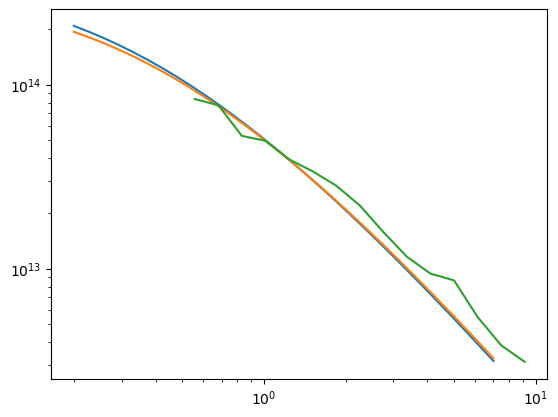

In [21]:
mean_ds = esd_modeling(radius, np.log10(np.mean(m)), 
                       concDiemer15._concentration(cosmo_ccl, np.mean(m), 1./(1. + np.mean(z))), np.mean(z), cosmo, 
                       halo_profile = 'nfw')
plt.loglog(radius, ds_mean)
plt.loglog(radius, mean_ds)
plt.errorbar(profiles['radius'][0], profiles['gt'][index],)